In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

## Options

In [2]:
# parse options
problem = 'twelve_pieces_process.json' # 'pavilion_process.json' # 'twelve_pieces_process.json'
problem_subdir = 'results'

recompute_action_states = False
load_external_movements = False

In [3]:
from collections import namedtuple
PlanningArguments = namedtuple('PlanningArguments', ['problem', 'viewer', 'debug', 'diagnosis', 'id_only', 'solve_mode', 'viz_upon_found', 
                                             'save_now', 'write', 'plan_impacted', 'watch', 'step_sim', 'verbose'])
# args = PlanningArguments(problem, viewer, debug, diagnosis, id_only, solve_mode, viz_upon_found, save_now, write, plan_impacted, watch, step_sim, verbose)

## Parse process from json

In [4]:
import os
from termcolor import cprint
import pybullet_planning as pp
from integral_timber_joints.planning.parsing import parse_process, save_process_and_movements, get_process_path, save_process

In [5]:
process = parse_process(problem, subdir=problem_subdir)
result_path = get_process_path(problem, subdir='results')
if len(process.movements) == 0:
    cprint('No movements found in process, trigger recompute actions.', 'red')
    recompute_action_states = True
if recompute_action_states:
    cprint('Recomputing Actions and States', 'cyan')
    recompute_action_states(process)

Process json parsed from c:\users\harry\dropbox (mit)\code_ws_dropbox\itj_ws\integral_timber_joints\external\itj_design_study\210128_RemodelFredPavilion\results\twelve_pieces_process.json


## read jsons

In [252]:
# from collections import defaultdict
import json

# file_name = 'b4_runtime_data_w_TC_final_nonlinear.json'
notc_file_name = 'b4_runtime_data_No_TC_final_all.json'
tc_file_name = 'b4_runtime_data_w_TC_nonlinear_40_trials.json'
tc_file_name2 = 'b4_runtime_data_w_TC_final_linear.json'

# b4_runtime_data_No_TC_21-07-06_11-54-15.json, on-going
# 'b1_runtime_data_w_TC_21-07-06_07-35-29.json'
#'b4_runtime_data_No_TC_21-07-06_00-04-45.json', 600 timeout, before bug fixed
# 'b4_runtime_data_No_TC_21-07-05_19-59-42.json' 1800 timeout, before bug fixed

runtime_data = {}
with open('figs/{}'.format(notc_file_name), 'r') as f:
    runtime_data['notc'] = json.load(f)

runtime_data['tc'] = {}
with open('figs/{}'.format(tc_file_name), 'r') as f:
    runtime_data['tc'].update(json.load(f))
with open('figs/{}'.format(tc_file_name2), 'r') as f:
    runtime_data['tc'].update(json.load(f))
    
print(runtime_data['notc'].keys())
print(runtime_data['tc'].keys())

dict_keys(['nonlinear', 'linear_forward', 'linear_backward'])
dict_keys(['nonlinear', 'linear_forward', 'linear_backward'])


## B4-Histogram

In [253]:
from collections import defaultdict

# aggregate all success/failure trials
agg_data = {'notc':{}, 'tc':{}}

for tc_flag in runtime_data:
    for solve_mode_ in runtime_data[tc_flag]:
        agg_data[tc_flag][solve_mode_] = defaultdict(list)
        cnt = 0
        for outer_trial_i, tdata in runtime_data[tc_flag][solve_mode_].items():
            for inner_trial_j_data in tdata.values():
                runtime_per_move = [sum(inner_trial_j_data['profiles'][mid]['plan_time']) \
                                    for mid in inner_trial_j_data['profiles']]
                runtime_key = 'success' if inner_trial_j_data['success'] else 'failure'
                agg_data[tc_flag][solve_mode_]['history'].append((inner_trial_j_data['success'], sum(runtime_per_move)))
#                 if cnt < sample_num:
                agg_data[tc_flag][solve_mode_][runtime_key].append(sum(runtime_per_move))
                cnt += 1

In [254]:
# agg_data['tc']

37


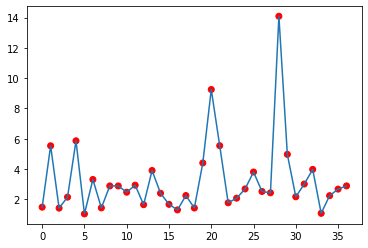

In [255]:
fig, ax = plt.subplots()
history = agg_data['tc']['linear_forward']['history'][:37]
print(len(history))

ax.plot(range(len(history)), [h[1] for h in history])
ax.scatter(range(len(history)), [h[1] for h in history], c=['g' if h[0] else 'r' for h in history])

In [256]:
import numpy as np
total_attempts = 37
plot_data = {'notc':{}, 'tc':{}}
for tc_flag in agg_data:
    for solve_mode, solve_data in agg_data[tc_flag].items():
        history = solve_data['history'][0:total_attempts]
        success_runs = [h[1] for h in history if h[0]]
        failed_runs = [h[1] for h in history if not h[0]]
        
        success_rate = len(success_runs) / len(history)
        success_mean = np.mean(success_runs)
        success_std = np.std(success_runs)
        failure_mean = np.mean(failed_runs)
        failure_std = np.std(failed_runs)

        plot_data[tc_flag][solve_mode] = {}
        plot_data[tc_flag][solve_mode]['total_attempts'] = len(history)
        plot_data[tc_flag][solve_mode]['success_rate'] = success_rate
        plot_data[tc_flag][solve_mode]['success_mean'] = success_mean
        plot_data[tc_flag][solve_mode]['success_std'] = success_std
        plot_data[tc_flag][solve_mode]['failure_mean'] = failure_mean
        plot_data[tc_flag][solve_mode]['failure_std'] = failure_std
        plot_data[tc_flag][solve_mode]['success_range'] = (success_mean-np.min(success_runs), np.max(success_runs)-success_mean) 
            if success_runs else (0,0)
        plot_data[tc_flag][solve_mode]['failed_range'] = (failure_mean-np.min(failed_runs), np.max(failed_runs)-failure_mean)

In [257]:
plot_data

{'notc': {'nonlinear': {'total_attempts': 37,
   'success_rate': 0.2702702702702703,
   'success_mean': 183.31190173625947,
   'success_std': 35.2723796260672,
   'failure_mean': 90.24654189745586,
   'failure_std': 88.65378468129425,
   'success_range': (58.07317059040071, 42.49367744922637),
   'failed_range': (88.40528361002605, 142.28633054097492)},
  'linear_forward': {'total_attempts': 37,
   'success_rate': 0.16216216216216217,
   'success_mean': 221.33476622899374,
   'success_std': 87.35759033402068,
   'failure_mean': 129.6541915170608,
   'failure_std': 86.24958915260008,
   'success_range': (121.91873415311179, 113.27890364329019),
   'failed_range': (125.28219129962307, 165.09864184933323)},
  'linear_backward': {'total_attempts': 37,
   'success_rate': 0.10810810810810811,
   'success_mean': 203.89131754636765,
   'success_std': 64.14935681392863,
   'failure_mean': 120.56947146040021,
   'failure_std': 91.88949656435535,
   'success_range': (94.03173822164536, 74.5878356

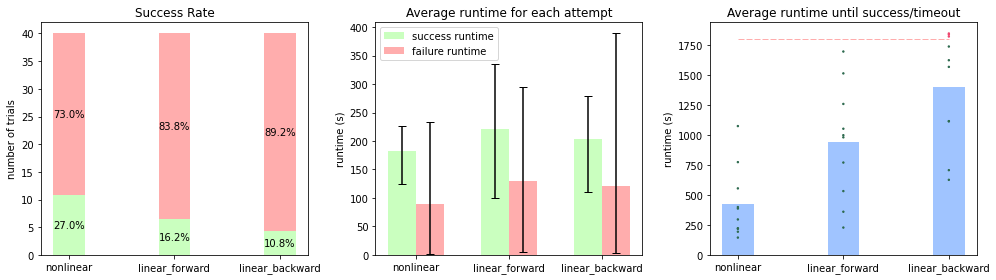

In [271]:
import matplotlib.pyplot as plt
import numpy as np

constriant_type = 'notc'
pp_data = plot_data[constriant_type]
x = np.arange(len(pp_data))  # the label locations
width = 0.3  # the width of the bars
success_green = '#caffbf'
failure_red = '#ffadad'
average_color = '#a0c4ff'

fig, ax = plt.subplots(1,3,figsize=(14,4)) # plt.figaspect(2)

# ! First figure
s_height = 40
rate_x = x
rate_alpha = 1.0
success_heights = [(pp_data[s]['success_rate'])*s_height for s in pp_data]
failed_heights = [(1-pp_data[s]['success_rate'])*s_height for s in pp_data]

rects1_1 = ax[0].bar(rate_x, success_heights, width, color=success_green, alpha=rate_alpha)
rects1_2 = ax[0].bar(rate_x, failed_heights, width, bottom=success_heights, color=failure_red, alpha=rate_alpha)
ax[0].bar_label(rects1_1, labels=['{:.1f}%'.format(pp_data[s]['success_rate']*100) for s in pp_data], 
             label_type='center') #padding=3)
ax[0].bar_label(rects1_2, labels=['{:.1f}%'.format((1-pp_data[s]['success_rate'])*100) for s in pp_data], 
             label_type='center') #padding=3)
ax[0].set_ylabel('number of trials')
ax[0].set_xticks(x)
ax[0].set_xticklabels(pp_data)
# ax[0].legend()
ax[0].set_title('Success Rate')

# ! Second Figure
rects2 = ax[1].bar(x - width/2,     [pp_data[s]['success_mean'] for s in pp_data], width,
                yerr=[[pp_data[s]['success_range'][0] for s in pp_data], [pp_data[s]['success_range'][1] for s in pp_data]], 
                label='success runtime', 
                color=success_green, ecolor='black', capsize=4)

rects3 = ax[1].bar(x + width/2, [pp_data[s]['failure_mean'] for s in pp_data], width, 
                yerr=[[pp_data[s]['failed_range'][0] for s in pp_data], [pp_data[s]['failed_range'][1] for s in pp_data]],
                label='failure runtime', 
                color=failure_red, ecolor='black', capsize=4)

ax[1].set_ylabel('runtime (s)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(pp_data)
ax[1].legend(loc='upper center')
ax[1].legend()
ax[1].set_title('Average runtime for each attempt')
# average time to obtain a successful result

# ! Third Figure
timeout = 600*3
data_summary = {}
for solve_mode, solve_mode_data in runtime_data[constriant_type].items():
    runtime_per_trial = []
    for outer_trial_data in solve_mode_data.values():
        runtime_per_inner = []
        for inner_trial_j_data in outer_trial_data.values():
            runtime_per_inner.append(sum([sum(inner_trial_j_data['profiles'][mid]['plan_time']) \
                                          for mid in inner_trial_j_data['profiles']]))
        runtime_per_trial.append(sum(runtime_per_inner))
    num_bts = [len(solve_mode_data[str(at)])-1 for at in range(len(solve_mode_data))]
    data_summary[solve_mode] = (np.average(runtime_per_trial), runtime_per_trial, num_bts)
bars = ax[2].bar(x, [d[0] for _, d in data_summary.items()], width, align='center', zorder=1, color=average_color)

# scatter points
for tx, rdata in zip(x, data_summary.values()):
    inner_runtimes = rdata[1]
    ax[2].scatter([tx for _ in inner_runtimes], inner_runtimes, c=['#2d6a4f' if rt < timeout else '#ef476f' \
                                                                   for rt in inner_runtimes], s=2.0, zorder=2) # label
#     for t, bt in zip(inner_runtimes, rdata[2]):
#         ax[2].annotate(bt, (tx+0.05, t), fontsize=7)
# timeout
ax[2].plot(x, [timeout for _ in x_pos], c=failure_red, dashes=[6, 2], label='timeout', zorder=2, lw=1)

# leg = ax[2].legend(loc='right')
ax[2].set_xticks(x)
ax[2].set_xticklabels(data_summary)
ax[2].set_ylabel('runtime (s)')
ax[2].set_title('Average runtime until success/timeout')

fig.tight_layout()
# all: comparison between linear and nonlinear planning b4's all movements (xx robot movements)
# a: success rate, b: runtime for each attempt, c: average runtime until success

plt.savefig(os.path.join('figs','10_beam4_runtime_without_TC.svg'))
plt.savefig(os.path.join('figs','10_beam4_runtime_without_TC.png'))

plt.show()

In [264]:
# ! Third Figure
tc_file_name = 'b4_runtime_data_w_TC_final_nonlinear.json'
tc_file_name2 = 'b4_runtime_data_w_TC_final_linear.json'

tc_runtime_data = {}
with open('figs/{}'.format(tc_file_name), 'r') as f:
    tc_runtime_data.update(json.load(f))
with open('figs/{}'.format(tc_file_name2), 'r') as f:
    tc_runtime_data.update(json.load(f))

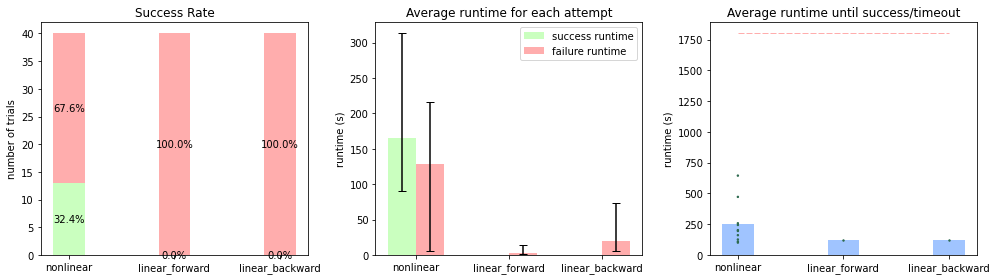

In [272]:
import matplotlib.pyplot as plt
import numpy as np

constriant_type = 'tc'
pp_data = plot_data[constriant_type]
x = np.arange(len(pp_data))  # the label locations
width = 0.3  # the width of the bars
success_green = '#caffbf'
failure_red = '#ffadad'
average_color = '#a0c4ff'

fig, ax = plt.subplots(1,3,figsize=(14,4)) # plt.figaspect(2)

# ! First figure
s_height = 40
rate_x = x
rate_alpha = 1.0
success_heights = [(pp_data[s]['success_rate'])*s_height for s in pp_data]
failed_heights = [(1-pp_data[s]['success_rate'])*s_height for s in pp_data]

rects1_1 = ax[0].bar(rate_x, success_heights, width, color=success_green, alpha=rate_alpha)
rects1_2 = ax[0].bar(rate_x, failed_heights, width, bottom=success_heights, color=failure_red, alpha=rate_alpha)
ax[0].bar_label(rects1_1, labels=['{:.1f}%'.format(pp_data[s]['success_rate']*100) for s in pp_data], 
             label_type='center') #padding=3)
ax[0].bar_label(rects1_2, labels=['{:.1f}%'.format((1-pp_data[s]['success_rate'])*100) for s in pp_data], 
             label_type='center') #padding=3)
ax[0].set_ylabel('number of trials')
ax[0].set_xticks(x)
ax[0].set_xticklabels(pp_data)
# ax[0].legend()
ax[0].set_title('Success Rate')

# ! Second Figure
rects2 = ax[1].bar(x - width/2,     [pp_data[s]['success_mean'] for s in pp_data], width,
                yerr=[[pp_data[s]['success_range'][0] for s in pp_data], [pp_data[s]['success_range'][1] for s in pp_data]], 
                label='success runtime', 
                color=success_green, ecolor='black', capsize=4)

rects3 = ax[1].bar(x + width/2, [pp_data[s]['failure_mean'] for s in pp_data], width, 
                yerr=[[pp_data[s]['failed_range'][0] for s in pp_data], [pp_data[s]['failed_range'][1] for s in pp_data]],
                label='failure runtime', 
                color=failure_red, ecolor='black', capsize=4)

ax[1].set_ylabel('runtime (s)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(pp_data)
ax[1].legend(loc='upper center')
ax[1].legend()
ax[1].set_title('Average runtime for each attempt')
# average time to obtain a successful result

# ! Third Figure
timeout = 600*3
data_summary = {}
for solve_mode, solve_mode_data in tc_runtime_data.items():
    runtime_per_trial = []
    for outer_trial_data in solve_mode_data.values():
        runtime_per_inner = []
        for inner_trial_j_data in outer_trial_data.values():
            runtime_per_inner.append(sum([sum(inner_trial_j_data['profiles'][mid]['plan_time']) \
                                          for mid in inner_trial_j_data['profiles']]))
        runtime_per_trial.append(sum(runtime_per_inner))
    num_bts = [len(solve_mode_data[str(at)])-1 for at in range(len(solve_mode_data))]
    data_summary[solve_mode] = (np.average(runtime_per_trial), runtime_per_trial, num_bts)
bars = ax[2].bar(x, [d[0] for _, d in data_summary.items()], width, align='center', zorder=1, color=average_color)

# scatter points
for tx, rdata in zip(x, data_summary.values()):
    inner_runtimes = rdata[1]
    ax[2].scatter([tx for _ in inner_runtimes], inner_runtimes, c=['#2d6a4f' if rt < timeout else '#ef476f' \
                                                                   for rt in inner_runtimes], s=2.0, zorder=2) # label
#     for t, bt in zip(inner_runtimes, rdata[2]):
#         ax[2].annotate(bt, (tx+0.05, t), fontsize=7)
# timeout
ax[2].plot(x, [timeout for _ in x_pos], c=failure_red, dashes=[6, 2], label='timeout', zorder=2, lw=1)

# leg = ax[2].legend(loc='right')
ax[2].set_xticks(x)
ax[2].set_xticklabels(data_summary)
ax[2].set_ylabel('runtime (s)')
ax[2].set_title('Average runtime until success/timeout')

fig.tight_layout()
# all: comparison between linear and nonlinear planning b4's all movements (xx robot movements)
# a: success rate, b: runtime for each attempt, c: average runtime until success

plt.savefig(os.path.join('figs','11_beam4_runtime_with_TC.svg'))
plt.savefig(os.path.join('figs','11_beam4_runtime_with_TC.png'))

plt.show()

In [230]:
data_summary

{}

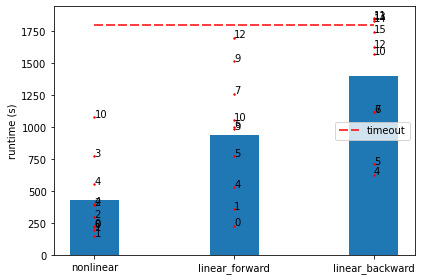

In [34]:
import matplotlib.pyplot as plt
import numpy as np

timeout = 600*3

fig, ax = plt.subplots()
data_summary = {}
for solve_mode, solve_mode_data in runtime_data.items():
    runtime_per_trial = []
    for outer_trial_data in solve_mode_data.values():
        runtime_per_inner = []
        for inner_trial_j_data in outer_trial_data.values():
            runtime_per_inner.append(sum([sum(inner_trial_j_data['profiles'][mid]['plan_time']) \
                                          for mid in inner_trial_j_data['profiles']]))
        runtime_per_trial.append(sum(runtime_per_inner))
    num_bts = [len(solve_mode_data[str(at)])-1 for at in range(len(solve_mode_data))]
    data_summary[solve_mode] = (np.average(runtime_per_trial), runtime_per_trial, num_bts)

width = 0.35  # the width of the bars
x_pos = np.arange(len(data_summary))
bars = ax.bar(x_pos, [d[0] for _, d in data_summary.items()], width, align='center', zorder=1)

# scatter points
for x, rdata in zip(x_pos, data_summary.values()):
    inner_runtimes = rdata[1]
    ax.scatter([x for _ in inner_runtimes], inner_runtimes, c='red', s=2.0, zorder=2) # label
    for t, bt in zip(inner_runtimes, rdata[2]):
        plt.annotate(bt, (x, t))

ax.plot(x_pos, [timeout for _ in x_pos], c='r', dashes=[6, 2], label='timeout', zorder=2)

leg = ax.legend(loc='right')
ax.set_xticks(x_pos)
ax.set_xticklabels(data_summary)
ax.set_ylabel('runtime (s)')

# import os
# plt.savefig(os.path.join('figs',file_name.split('.json')[0]+'_hist.png'))
fig.tight_layout()

plt.show()

# All beam scatter plot

In [65]:
# from collections import defaultdict
import json

file_names = {'b{}'.format(bid) : 'b{}_runtime_data_w_TC_{}.json'.format(bid, '21-07-06_23-04-03') \
              for bid in list(range(0,25)) + list(range(26,32))}
file_names.update(
    {'b{}'.format(bid) : 'b{}_runtime_data_w_TC_{}.json'.format(bid, '21-07-07_07-55-05') for bid in range(32,40)}
)

all_runtime_data = {}
for bid, fn in file_names.items():
    with open('figs/{}'.format(fn), 'r') as f:
        all_runtime_data[bid] = json.load(f)

print(all_runtime_data.keys())

dict_keys(['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23', 'b24', 'b26', 'b27', 'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39'])


In [66]:
all_runtime_data['b1']['nonlinear'].keys()

dict_keys(['0'])

In [67]:
# ['nonlinear', 'linear_forward', 'linear_backward']
for bid, beam_data in all_runtime_data.items():
    for solve_mode_ in beam_data:
        print('='*20)
        for i, tdata in beam_data[solve_mode_].items():
            print('{} | #{}-T#{}:'.format(bid, solve_mode_, i))
            sc = all([d['success'] for di, d in tdata.items()])

            total_runtime = []
            for i, trial_data in tdata.items():
                trial_profiles = trial_data['profiles']
                runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in trial_profiles]
                total_runtime.append(sum(runtime_per_move))
            tdata['total_runtime'] = sum(total_runtime)
            cprint('- {} - BT {} | time {:.2f}'.format(sc, len(tdata), sum(total_runtime)), 'green' if sc else 'red')
            print('---')

b0 | #nonlinear-T#0:
- True - BT 2 | time 22.86
---
b1 | #nonlinear-T#0:
- True - BT 2 | time 13.85
---
b2 | #nonlinear-T#0:
- True - BT 2 | time 163.00
---
b3 | #nonlinear-T#0:
- False - BT 3 | time 78.48
---
b4 | #nonlinear-T#0:
- False - BT 9 | time 1271.01
---
b5 | #nonlinear-T#0:
- True - BT 2 | time 58.98
---
b6 | #nonlinear-T#0:
- False - BT 11 | time 1827.63
---
b7 | #nonlinear-T#0:
- True - BT 2 | time 11.03
---
b8 | #nonlinear-T#0:
- False - BT 4 | time 382.68
---
b9 | #nonlinear-T#0:
- False - BT 3 | time 95.90
---
b10 | #nonlinear-T#0:
- False - BT 4 | time 392.30
---
b11 | #nonlinear-T#0:
- True - BT 2 | time 171.90
---
b12 | #nonlinear-T#0:
- True - BT 2 | time 129.33
---
b13 | #nonlinear-T#0:
- False - BT 11 | time 1552.85
---
b14 | #nonlinear-T#0:
- False - BT 3 | time 175.17
---
b15 | #nonlinear-T#0:
- False - BT 6 | time 380.87
---
b16 | #nonlinear-T#0:
- False - BT 4 | time 530.10
---
b17 | #nonlinear-T#0:
- False - BT 3 | time 99.48
---
b18 | #nonlinear-T#0:
- True 

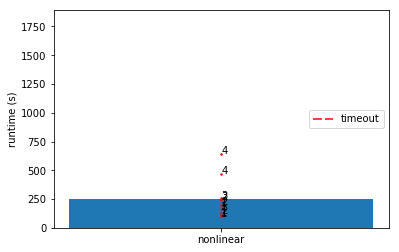

In [38]:
import matplotlib.pyplot as plt
import numpy as np

timeout = 600*3

fig, ax = plt.subplots()
data_summary = {}
for bid, beam_data in all_runtime_data.items():
for solve_mode, solve_mode_data in runtime_data.items():
    x = range(len(solve_mode_data))
    runtime_per_trial = [solve_mode_data[str(at)]['total_runtime'] for at in x]
    num_bts = [len(solve_mode_data[str(at)])-1 for at in x]
    data_summary[solve_mode] = (np.average(runtime_per_trial), runtime_per_trial, num_bts)

x_pos = np.arange(len(data_summary))
bars = ax.bar(x_pos, [d[0] for _, d in data_summary.items()], align='center', zorder=1)

# scatter points
for x, rdata in zip(x_pos, data_summary.values()):
    inner_runtimes = rdata[1]
    ax.scatter([x for _ in inner_runtimes], inner_runtimes, c='red', s=2.0, zorder=2) # label
    for t, bt in zip(inner_runtimes, rdata[2]):
        plt.annotate(bt, (x, t))

ax.plot(x_pos, [timeout for _ in x_pos], c='r', dashes=[6, 2], label='timeout', zorder=2)

leg = ax.legend(loc='right')
ax.set_xticks(x_pos)
ax.set_xticklabels(data_summary)
ax.set_ylabel('runtime (s)')

plt.draw() # Draw the figure so you can find the positon of the legend.

import os
plt.savefig(os.path.join('figs',file_name.split('.json')[0]+'_hist.png'))

plt.show()

## All-beam scatter plot

In [273]:
# from collections import defaultdict
import json

file_names = {bid : 'b{}_runtime_data_w_TC_{}.json'.format(bid, '21-07-06_23-04-03') \
                  for bid in list(range(0,25)) + list(range(26,32))}
file_names.update(
    {bid : 'b{}_runtime_data_w_TC_{}.json'.format(bid, '21-07-07_07-55-05') for bid in range(32,40)}
)

for bid in [6,29,36]:
    file_names[bid] = 'b{}_runtime_data_w_TC_21-07-08_17-21-22.json'.format(bid)
for bid in [25,34]:
    file_names[bid] = 'b{}_runtime_data_w_TC_21-07-07_21-58-12.json'.format(bid)
    
runtime_per_beam = {}
for bid, fn in file_names.items():
    runtime_data = {}
    with open('figs/{}'.format(fn), 'r') as f:
        runtime_data = json.load(f)

    # ['nonlinear', 'linear_forward', 'linear_backward']
    for solve_mode_ in runtime_data:
        print('='*20)
        for i, tdata in runtime_data[solve_mode_].items():
            print('b{} | #{}-T#{}:'.format(bid, solve_mode_, i))
            sc = any([d['success'] for di, d in tdata.items()])

            total_runtime = []
            for i, trial_data in tdata.items():
                trial_profiles = trial_data['profiles']
                runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in trial_profiles]
                total_runtime.append(sum(runtime_per_move))
            tdata['total_runtime'] = sum(total_runtime)
            # !
            runtime_per_beam[bid] = (sum(total_runtime), len(tdata))
            cprint('{} - BT {} | time {:.2f}'.format(sc, len(tdata), sum(total_runtime)), 'green' if sc else 'red')
            print('---')

b0 | #nonlinear-T#0:
True - BT 2 | time 22.86
---
b1 | #nonlinear-T#0:
True - BT 2 | time 13.85
---
b2 | #nonlinear-T#0:
True - BT 2 | time 163.00
---
b3 | #nonlinear-T#0:
True - BT 3 | time 78.48
---
b4 | #nonlinear-T#0:
True - BT 9 | time 1271.01
---
b5 | #nonlinear-T#0:
True - BT 2 | time 58.98
---
b6 | #nonlinear-T#0:
True - BT 5 | time 259.35
---
b7 | #nonlinear-T#0:
True - BT 2 | time 11.03
---
b8 | #nonlinear-T#0:
True - BT 4 | time 382.68
---
b9 | #nonlinear-T#0:
True - BT 3 | time 95.90
---
b10 | #nonlinear-T#0:
True - BT 4 | time 392.30
---
b11 | #nonlinear-T#0:
True - BT 2 | time 171.90
---
b12 | #nonlinear-T#0:
True - BT 2 | time 129.33
---
b13 | #nonlinear-T#0:
True - BT 11 | time 1552.85
---
b14 | #nonlinear-T#0:
True - BT 3 | time 175.17
---
b15 | #nonlinear-T#0:
True - BT 6 | time 380.87
---
b16 | #nonlinear-T#0:
True - BT 4 | time 530.10
---
b17 | #nonlinear-T#0:
True - BT 3 | time 99.48
---
b18 | #nonlinear-T#0:
True - BT 2 | time 79.31
---
b19 | #nonlinear-T#0:
True 

In [ ]:
13,25,32,34,37,38,39

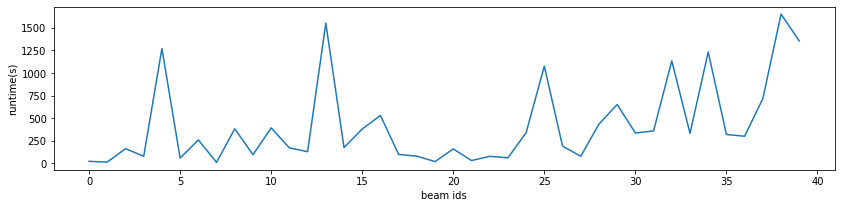

In [288]:
import matplotlib.pyplot as plt
import numpy as np

timeout = 600*3

fig, ax = plt.subplots(figsize=(14,3))
beams = list(sorted(runtime_per_beam.keys()))
# plt.scatter(beams, [runtime_per_beam[b][0] for b in beams], s=5)
# plt.bar(beams, [runtime_per_beam[b][0] for b in beams])
plt.plot(beams, [runtime_per_beam[b][0] for b in beams])
# for b in beams:
#     plt.annotate(runtime_per_beam[b][1], (b, runtime_per_beam[b][0]))

# plt.plot(beams, [timeout for _ in beams], c='r', label='timeout')
ax.set_xlabel('beam ids')
ax.set_ylabel('runtime(s)')

import os
plt.savefig(os.path.join('figs','all_beam_runtime.svg'))
plt.savefig(os.path.join('figs','all_beam_runtime.png'))

plt.show()

# all beams, until success, no timeout

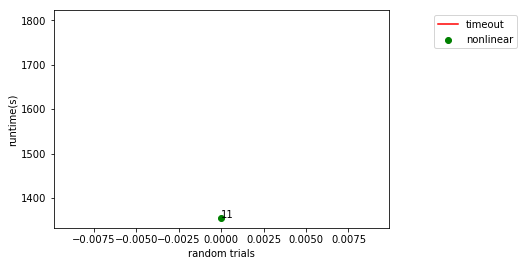

In [69]:
import matplotlib.pyplot as plt
import numpy as np

timeout = 600*3

fig, ax = plt.subplots()
markers = ['o', '^', (5, 0)]
mcolors = ['g', 'r', 'b']
for marker, mcolor, (solve_m, solve_mode_data) in zip(markers, mcolors, runtime_data.items()):
    x = range(len(solve_mode_data))
    runtime_per_trial = [solve_mode_data[str(at)]['total_runtime'] for at in x]
    num_bts = [len(solve_mode_data[str(at)])-1 for at in x]
    plt.scatter(x, runtime_per_trial, marker=marker, c=mcolor, label=solve_m)
    for i in x:
        plt.annotate(num_bts[i], (i, runtime_per_trial[i]))

plt.plot(x, [timeout for _ in x], c='r', label='timeout')
        
ax.set_xlabel('random trials')
ax.set_ylabel('runtime(s)')
# ax.set_title('Runtime by sovl')
leg = ax.legend(loc='upper right')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())

# Change to location of the legend. 
xOffset = 0.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

# import os
# plt.savefig(os.path.join('figs',file_name.split('.json')[0]+'.png'))

plt.show()

## Single result

In [156]:
fn = 'b6_runtime_data_w_TC_21-07-07_21-58-12.json'

single_runtime_data = {}
with open('figs/{}'.format(fn), 'r') as f:
    single_runtime_data = json.load(f)

In [159]:
# ['nonlinear', 'linear_forward', 'linear_backward']

for bid in [6,25,29,34,36]:
    fn = 'b{}_runtime_data_w_TC_21-07-07_21-58-12.json'.format(bid)

    single_runtime_data = {}
    with open('figs/{}'.format(fn), 'r') as f:
        single_runtime_data = json.load(f)

    beam_id = fn.split('_')[0]
    for solve_mode_ in single_runtime_data:
        print('='*20)
        for i, tdata in single_runtime_data[solve_mode_].items():
            print('{} | #{}-T#{}:'.format(beam_id, solve_mode_, i))
            sc = any([d['success'] for di, d in tdata.items()])

            total_runtime = []
            for i, trial_data in tdata.items():
                trial_profiles = trial_data['profiles']
                runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in trial_profiles]
                total_runtime.append(sum(runtime_per_move))
    #         tdata['total_runtime'] = sum(total_runtime)
            cprint('{} - BT {} | time {:.2f}'.format(sc, len(tdata), sum(total_runtime)), 'green' if sc else 'red')
            print('---')

b6 | #nonlinear-T#0:
False - BT 14 | time 1899.58
---
b25 | #nonlinear-T#0:
True - BT 15 | time 1077.00
---
b29 | #nonlinear-T#0:
False - BT 10 | time 1852.02
---
b34 | #nonlinear-T#0:
True - BT 9 | time 1233.37
---
b36 | #nonlinear-T#0:
False - BT 11 | time 1838.60
---


# Detailed diagram

In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from integral_timber_joints.process import RoboticFreeMovement, RoboticLinearMovement, RoboticClampSyncLinearMovement

# solve_mode_ = 'linear_forward' # linear_backward | linear_forward | nonlinear
beam_id = file_name.split('_runtime_data')[0]

# total_rows = 0
# for i, d in runtime_data[solve_mode_].items():
#     total_rows += len(d)+1
max_inner_loop_displayed = 11

for solve_mode_ in runtime_data:
    for attempt_i, s_rdata in runtime_data[solve_mode_].items():
        if 'total_runtime' in s_rdata:
            del s_rdata['total_runtime']
        if len(s_rdata) > max_inner_loop_displayed:
            num_rows = max_inner_loop_displayed+1
            half = int(max_inner_loop_displayed/2)
            selected_inners = list(range(0,half)) + list(range(len(s_rdata)-half,len(s_rdata)))
        else:
            num_rows = len(s_rdata)+1
            selected_inners = list(range(len(s_rdata)))

        fig = make_subplots(rows=num_rows, cols=2)
        success = any([d['success'] for di, d in s_rdata.items()])
        total_runtime = []
        failed_m_id = []
        for i in s_rdata.keys():
            trial_data = s_rdata[i]
            trial_profiles = trial_data['profiles']
            mid_keys = sorted(trial_profiles.keys(), key=int)
            runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in mid_keys]
            total_runtime.append(sum(runtime_per_move))

            for mid in mid_keys:
                if not any(trial_profiles[mid]['plan_success']):
                    movement = process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0])
                    m_color = '#ff1b6b' if isinstance(movement, RoboticFreeMovement) else '#45caff'
                    failed_m_id.append((mid, movement.short_summary, m_color))
                    break
            else:
                failed_m_id.append((-1, 'success!', '#00ff87'))

            if i in selected_inners or int(i) in selected_inners:
                success_colors = ['#99C24D' if any(trial_profiles[mid]['plan_success']) else '#F18F01' for mid in mid_keys]
                row_id = selected_inners.index(int(i))+1
                fig.append_trace(go.Scatter(x=mid_keys,
                                        y=runtime_per_move,
                                        mode='markers',
                                        marker_color=success_colors,
                                        text=[process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0]).short_summary \
                                              for mid in mid_keys], # hover text goes here
                                        name='#{}-feasibility'.format(i),
                                        ),
                              row=row_id, col=1
                            )

                fig.append_trace(go.Scatter(x=mid_keys,
                                                y=runtime_per_move,
                                                mode='markers',
                                                    marker=dict(
                                                    size=5,
                                                    color=[trial_profiles[mid]['sample_order'][0] for mid in mid_keys], #set color equal to a variable
                                                    colorscale='Viridis', # one of plotly colorscales
                                                    showscale=True
                                                ),
                                                text=['S#{}-{}'.format(trial_profiles[mid]['sample_order'][0], process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0]).short_summary) \
                                                      for mid in mid_keys], # hover text goes here
                                                name='#{}-sample order'.format(i),),
                              row=row_id, col=2
                                )
                if row_id == 1:
                    fig.update_xaxes(title_text="m_id",row=row_id, col=1)
                    fig.update_yaxes(title_text="runtime(s)",row=row_id, col=1)

        fig.append_trace(go.Scatter(x=list(range(len(s_rdata))),y=total_runtime), 
                         row=num_rows, col=1)
        fig.update_xaxes(title_text="trials",row=num_rows, col=1)
        fig.update_yaxes(title_text="runtime(s)",row=num_rows, col=1)

        fig.append_trace(go.Scatter(x=list(range(len(failed_m_id))),y=[int(tt[0]) for tt in failed_m_id],
                                    mode='markers',
                                    marker_color=[tt[2] for tt in failed_m_id],
                                    text=[tt[1] for tt in failed_m_id],
                                   ), row=num_rows, col=2)
        fig.update_xaxes(title_text="trials",row=num_rows, col=2)
        fig.update_yaxes(title_text="failed_movement_id",row=num_rows, col=2)


        title = "figs/{}-{}-trail_{}_success-{}_BT-{}_time-{:.1f}".format(beam_id, solve_mode_, 
            attempt_i, success, len(s_rdata), sum(total_runtime))
        fig.update_layout(title=title)
        fig.write_html(title + ".html")
# fig.show()

In [41]:
len(failed_m_id)

207

# Save runtime data

In [106]:
runtime_data.keys()

dict_keys(['linear', 'nonlinear'])

## Start client

In [10]:
from integral_timber_joints.planning.robot_setup import load_RFL_world
from integral_timber_joints.planning.run import set_initial_state

# * Connect to path planning backend and initialize robot parameters
# viewer or diagnosis or view_states or watch or step_sim,
client, robot, _ = load_RFL_world(viewer=False, verbose=False)
set_initial_state(client, robot, process, disable_env=disable_env, reinit_tool=False)

argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
x_railb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
robot11_tool0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
robot12_tool0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/Bull

In [32]:
client.disconnect()

# Visualize traj

In [17]:
from integral_timber_joints.planning.state import set_state
from integral_timber_joints.planning.visualization import visualize_movement_trajectory

altered_ms = [process.get_movement_by_movement_id('A43_M2')]
set_state(client, robot, process, process.initial_state)
for altered_m in altered_ms:
    visualize_movement_trajectory(client, robot, process, altered_m, step_sim=False, step_duration=0.05)

===
Viz:
No traj found for RoboticLinearMovement(#A43_M2, Linear Approach 2 of 2 to place CL3 ('c2') in storage., traj 0)
 -- has_start_conf False, has_end_conf True
Press enter to continue


# Disconnect client

In [48]:
client.disconnect()

# Plan only one movement

In [29]:
# if id_only:
#     beam_id = process.get_beam_id_from_movement_id(id_only)
#     process.get_movement_summary_by_beam_id(beam_id)

In [39]:
from integral_timber_joints.planning.stream import compute_free_movement, compute_linear_movement
from integral_timber_joints.planning.solve import compute_movement

chosen_m = process.get_movement_by_movement_id(id_only)
compute_movement(client, robot, process, chosen_m, options=lm_options, diagnosis=diagnosis)

RoboticLinearMovement(#A2_M1, Linear Advance to Final Frame of Beam ('b0'), traj 1)
end conf FK inconsistent (0.00005 m) with given current frame in end state.
Both start/end confs are pre-specified, problem might be too stiff to be solved.
One-sided Cartesian planning : start conf set, forward mode
	cartesian trial #0
Plan found by IterativeIK! After 0 path failure (by IterativeIK) over 1 samples.


True

In [40]:
from integral_timber_joints.planning.visualization import visualize_movement_trajectory

with pp.WorldSaver():
    visualize_movement_trajectory(client, robot, process, chosen_m, step_sim=True)

===
Viz:
RoboticLinearMovement(#A2_M1, Linear Advance to Final Frame of Beam ('b0'), traj 1)


Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
End state. 


# Debug

In [114]:
prev_m = process.get_movement_by_movement_id('A40_M6')
start_state = process.get_movement_start_state(prev_m)
end_state = process.get_movement_end_state(prev_m)

# v = end_state['robot'].current_frame.point - start_state['robot'].current_frame.point
# list(v)
set_state(client, robot, process, end_state)
print(end_state['tool_changer'].current_frame)
print(client.get_object_frame('^tool_changer$', scale=1e3)[75])

{
    "point": [
        16365.955352783203,
        5373.7616539001465,
        1185.3845119476318
    ],
    "xaxis": [
        -0.2580321229101535,
        0.6278875467781188,
        0.7342864918731894
    ],
    "yaxis": [
        -0.9661363350844321,
        -0.1677526279329609,
        -0.19606029136775213
    ]
}
{
    "point": [
        16365.955352783203,
        5373.7616539001465,
        1185.3845119476318
    ],
    "xaxis": [
        -0.25803212291015387,
        0.6278875467781186,
        0.7342864918731893
    ],
    "yaxis": [
        -0.9661363350844319,
        -0.16775262793296133,
        -0.19606029136775227
    ]
}


In [109]:
client.set_robot_configuration(robot, end_state['robot'].kinematic_config)
print(client.get_object_frame('^tool_changer$', scale=1e3)[75])

{
    "point": [
        16365.961074829102,
        5373.770236968994,
        1185.3852272033691
    ],
    "xaxis": [
        -0.2580321229101535,
        0.6278875467781188,
        0.7342864918731894
    ],
    "yaxis": [
        -0.9661363350844321,
        -0.1677526279329609,
        -0.19606029136775213
    ]
}


In [116]:
from compas_fab_pychoreo.backend_features.pychoreo_configuration_collision_checker import PyChoreoConfigurationCollisionChecker

set_state(client, robot, process, end_state, options=options)
# set_state(client, robot, process, start_state, options=options)
pychore_collision_fn = PyChoreoConfigurationCollisionChecker(client)
# end_state['robot'].kinematic_config
options['diagnosis'] = True
pychore_collision_fn.check_collisions(robot, prev_m.trajectory.points[-2], options=options)

False

In [79]:
tc_body = client.pychoreo_attachments['tool_changer']

In [83]:
from compas_fab_pychoreo.conversions import pose_from_frame, frame_from_pose

frame_from_pose(pp.get_pose(75))

Frame(Point(0.016, 0.005, 0.001), Vector(-0.258, 0.628, 0.734), Vector(-0.966, -0.168, -0.196))

In [75]:
client.get_object_frame('^tool_changer$')

{75: Frame(Point(16.366, 5.374, 1.185), Vector(-0.258, 0.628, 0.734), Vector(-0.966, -0.168, -0.196))}

In [44]:
print(end_state['robot'])
print(end_state['tool_changer'])

State: current frame: {
    "point": [
        16365.989685058594,
        5373.808860778809,
        1185.4075193405151
    ],
    "xaxis": [
        -0.25802939931448104,
        0.6277901217809272,
        0.7343707456616834
    ],
    "yaxis": [
        -0.9661370648091927,
        -0.16763997964096333,
        -0.1961530250285612
    ]
} | config: JointTrajectoryPoint((15.468, -4.130, -2.020, 2.159, -0.587, -2.805, 0.492, -2.039, 0.908), (2, 2, 2, 0, 0, 0, 0, 0, 0), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), Duration(11, 0)) | attached to robot: False
State: current frame: {
    "point": [
        16366.001562499872,
        5373.822840010225,
        1185.408652972277
    ],
    "xaxis": [
        -0.2580290176609404,
        0.6277482599146081,
        0.7344066640622972
    ],
    "yaxis": [
        -0.9661371673033442,
        